In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import os

In [476]:
df_train = pd.read_csv(
    "~/.kaggle/data/rossmann-store-sales/train.csv",
    low_memory=False,
    parse_dates=["Date"],
)
df_store = pd.read_csv(
    "~/.kaggle/data/rossmann-store-sales/store.csv", low_memory=False
)

In [481]:
df_store = pd.read_csv(
    "~/.kaggle/data/rossmann-store-sales/store.csv", low_memory=False
).set_index("Store")

df_store["CompetitionOpenSince"] = pd.to_datetime(
    {
        "year": df_store["CompetitionOpenSinceYear"],
        "month": df_store["CompetitionOpenSinceMonth"],
        "day": 1,
    }
)

df_store = df_store.fillna(
    {
        "Promo2SinceWeek": 0,
        "Promo2SinceYear": 0,
        "PromoInterval": 0,
        "CompetitionDistance": df_store["CompetitionDistance"].median(),
        "CompetitionOpenSince": df_store["CompetitionOpenSince"].median(),
    }
)


df_store = df_store.drop(
    columns=["CompetitionOpenSinceYear", "CompetitionOpenSinceMonth"]
)

# state_holiday_sales = df_train.loc[
#     df_train["StateHoliday"] != "0", ["Store", "Date"]
# ].copy()
# # state_holiday_sales["MonthDay"] = pd.Series(zip(state_holiday_sales["Date"].dt.month, state_holiday_sales["Date"].dt.day), index=state_holiday_sales.index)  # type: ignore
# state_holiday_scheme = (
#     state_holiday_sales.groupby("Store")["Date"].agg(set).apply(sorted).apply(tuple)
# )
# state_holiday_scheme_encoder = LabelEncoder()
# df_store["StateHolidayScheme"] = state_holiday_scheme_encoder.fit_transform(
#     state_holiday_scheme
# )

# school_holiday_sales = df_train.loc[
#     df_train["SchoolHoliday"] == 1, ["Store", "Date"]
# ].copy()
# # school_holiday_sales["MonthDay"] = pd.Series(zip(school_holiday_sales["Date"].dt.month, school_holiday_sales["Date"].dt.day), index=school_holiday_sales.index)  # type: ignore
# school_holiday_scheme = (
#     school_holiday_sales.groupby("Store")["Date"].agg(set).apply(sorted).apply(tuple)
# )
# school_holiday_scheme_encoder = LabelEncoder()
# df_store["SchoolHolidayScheme"] = school_holiday_scheme_encoder.fit_transform(
#     school_holiday_scheme
# )

# df_store.to_csv("stores.csv")

In [483]:
df_train["Open"].value_counts()

Open
1    844392
0    172817
Name: count, dtype: int64

(array([179.,   1.,   1.,   2.,  31., 870.,   1.,   1.,  14.,  15.]),
 array([592., 627., 662., 697., 732., 767., 802., 837., 872., 907., 942.]),
 <BarContainer object of 10 artists>)

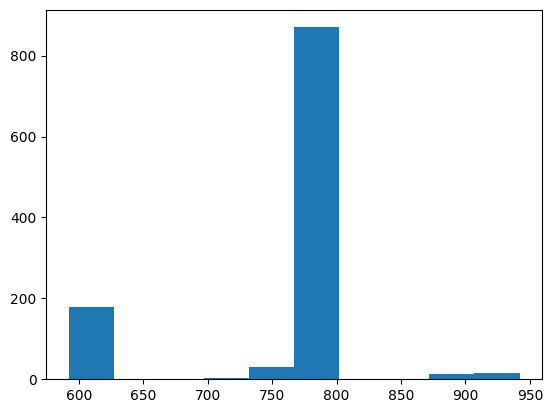

In [492]:
x = df_train[df_train["Sales"] > 0].groupby("Store")["Date"].agg("count")
plt.hist(x)

In [493]:
print(x[x < 650].max(), x[x >= 650].min())
print(x[x < 825].max(), x[x >= 825].min())

631 687
806 862


In [495]:
len(set(df_train["Date"]))

942

In [496]:
x.min(), x.max()

(np.int64(592), np.int64(942))

In [521]:
len(x[x > 806])
len(x[x > 860])

30

In [530]:
len(x[x < 687])

180

In [ ]:
1.1 * x.min()

np.float64(651.2)

In [537]:
days_open = df_train[df_train["Open"] == 1].groupby("Store")["Date"].count()

(array([179.,   1.,   1.,   2.,  28., 873.,   1.,   1.,  14.,  15.]),
 array([592., 627., 662., 697., 732., 767., 802., 837., 872., 907., 942.]),
 <BarContainer object of 10 artists>)

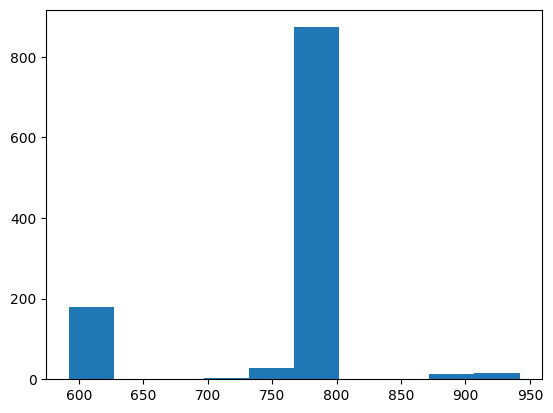

In [553]:
v = days_open
plt.hist(v)

In [570]:
df_train[df_train["Date"].dt.year == 2013]["Sales"].mean()

np.float64(5658.533675369926)

In [571]:
df_train[df_train["Date"].dt.year == 2014]["Sales"].mean()

np.float64(5833.290703615038)

In [572]:
df_train[df_train["Date"].dt.year == 2015]["Sales"].mean()

np.float64(5878.245380319824)

In [201]:
# df = df_train.merge(
#     df_store,
#     on="Store",
#     how="left",
# )
# df

In [ ]:
month_day_pairs = pd.Series(
    sorted(set(zip(df_train["Date"].dt.month, df_train["Date"].dt.day)))
)
month, day = zip(*month_day_pairs)
month = np.array(month)
day = np.array(day)

In [298]:
dates = pd.Series(sorted(set(df_train["Date"])))

In [304]:
state_holidays = pd.DataFrame({"Date": dates})
for i, c in enumerate(state_holiday_scheme_encoder.classes_):
    state_holidays.loc[:, i] = dates.isin(c).astype(int)

state_holidays = pd.melt(
    state_holidays,
    id_vars=["Date"],
    var_name="StateHolidayScheme",
    value_name="IsStateHoliday",
).set_index(["Date", "StateHolidayScheme"])

school_holidays = pd.DataFrame({"Date": dates})
for i, c in enumerate(school_holiday_scheme_encoder.classes_):
    school_holidays.loc[:, i] = dates.isin(c).astype(int)

school_holidays = pd.melt(
    school_holidays,
    id_vars=["Date"],
    var_name="SchoolHolidayScheme",
    value_name="IsSchoolHoliday",
).set_index(["Date", "SchoolHolidayScheme"])


state_holidays.to_csv("state_holidays.csv")
# school_holidays.to_csv("school_holidays.csv")

In [305]:
state_holidays

,,IsStateHoliday
Date,StateHolidayScheme,
2013-01-01,0,1
2013-01-02,0,0
2013-01-03,0,0
2013-01-04,0,0
2013-01-05,0,0
...,...,...
2015-07-27,8,0
2015-07-28,8,0
2015-07-29,8,0


In [204]:
df_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Day
0,1,5,2015-07-31,5263,555,1,1,0,1,7,31
1,2,5,2015-07-31,6064,625,1,1,0,1,7,31
2,3,5,2015-07-31,8314,821,1,1,0,1,7,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,7,31
4,5,5,2015-07-31,4822,559,1,1,0,1,7,31
...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1,1


In [306]:
df = df_train.merge(
    df_store,
    on="Store",
    how="left",
)
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,...,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince,StateHolidayScheme,SchoolHolidayScheme
0,1,5,2015-07-31,5263,555,1,1,0,1,7,...,c,a,1270.0,0,0.0,0.0,0,2008-09-01,5,0
1,2,5,2015-07-31,6064,625,1,1,0,1,7,...,a,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,6,6
2,3,5,2015-07-31,8314,821,1,1,0,1,7,...,a,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,4,10
3,4,5,2015-07-31,13995,1498,1,1,0,1,7,...,c,c,620.0,0,0.0,0.0,0,2009-09-01,7,4
4,5,5,2015-07-31,4822,559,1,1,0,1,7,...,a,a,29910.0,0,0.0,0.0,0,2015-04-01,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1,...,a,a,1900.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2014-06-01,4,10
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1,...,c,c,1880.0,0,0.0,0.0,0,2006-04-01,4,10
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1,...,a,c,9260.0,0,0.0,0.0,0,2010-02-01,7,8
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1,...,a,c,870.0,0,0.0,0.0,0,2010-02-01,7,3


In [311]:
x = df.join(state_holidays, on=["Date", "StateHolidayScheme"], how="left")

In [315]:
all((x["IsStateHoliday"] != 0) == (x["StateHoliday"] != "0"))

True

In [314]:
x["StateHoliday"] != "0"

0          False
1          False
2          False
3          False
4          False
           ...  
1017204     True
1017205     True
1017206     True
1017207     True
1017208     True
Name: StateHoliday, Length: 1017209, dtype: bool

In [310]:
assert all(x["IsSchoolHoliday"] == x["SchoolHoliday"])

In [251]:
sum(x["SchoolHoliday"])

181721

In [254]:
(7, 31) in school_holiday_scheme_encoder.classes_[7]

True

In [276]:
(7, 31) in school_holiday_scheme.loc[13]

True

In [ ]:
# school_holiday_scheme = (
#     school_holiday_sales.groupby("Store")["MonthDay"]
#     .agg(set)
#     .apply(sorted)
#     .apply(tuple)
# )

set(school_holiday_sales[school_holiday_sales["Store"] == 13]["MonthDay"]) == set(
    school_holiday_scheme.loc[13]
)

True

In [282]:
x.loc[12]

Store                                    13
DayOfWeek                                 5
Date                    2015-07-31 00:00:00
Sales                                  8821
Customers                               568
Open                                      1
Promo                                     1
StateHoliday                              0
SchoolHoliday                             0
Month                                     7
Day                                      31
StoreType                                 d
Assortment                                a
CompetitionDistance                   310.0
Promo2                                    1
Promo2SinceWeek                        45.0
Promo2SinceYear                      2009.0
PromoInterval               Feb,May,Aug,Nov
CompetitionOpenSince    2010-02-01 00:00:00
StateHolidayScheme                        0
SchoolHolidayScheme                       7
IsSchoolHoliday                           1
Name: 12, dtype: object

In [283]:
x

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,...,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince,StateHolidayScheme,SchoolHolidayScheme,IsSchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1,7,...,a,1270.0,0,0.0,0.0,0,2008-09-01,5,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1,7,...,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,6,10,1
2,3,5,2015-07-31,8314,821,1,1,0,1,7,...,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,4,2,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,7,...,c,620.0,0,0.0,0.0,0,2009-09-01,7,9,1
4,5,5,2015-07-31,4822,559,1,1,0,1,7,...,a,29910.0,0,0.0,0.0,0,2015-04-01,3,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1,...,a,1900.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2014-06-01,4,2,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1,...,c,1880.0,0,0.0,0.0,0,2006-04-01,4,2,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1,...,c,9260.0,0,0.0,0.0,0,2010-02-01,7,4,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1,...,c,870.0,0,0.0,0.0,0,2010-02-01,7,3,1


In [290]:
school_holiday_sales[school_holiday_sales["Store"] == 13]

,Store,Date,MonthDay
62452,13,2015-06-05,"(6, 5)"
63567,13,2015-06-04,"(6, 4)"
64682,13,2015-06-03,"(6, 3)"
65797,13,2015-06-02,"(6, 2)"
66912,13,2015-06-01,"(6, 1)"
...,...,...,...
970392,13,2013-02-11,"(2, 11)"
1012762,13,2013-01-04,"(1, 4)"
1013877,13,2013-01-03,"(1, 3)"
1014992,13,2013-01-02,"(1, 2)"


In [316]:
x

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,...,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince,StateHolidayScheme,SchoolHolidayScheme,IsStateHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1,7,...,a,1270.0,0,0.0,0.0,0,2008-09-01,5,0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,7,...,a,570.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,6,6,0
2,3,5,2015-07-31,8314,821,1,1,0,1,7,...,a,14130.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,4,10,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,7,...,c,620.0,0,0.0,0.0,0,2009-09-01,7,4,0
4,5,5,2015-07-31,4822,559,1,1,0,1,7,...,a,29910.0,0,0.0,0.0,0,2015-04-01,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1,...,a,1900.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2014-06-01,4,10,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1,...,c,1880.0,0,0.0,0.0,0,2006-04-01,4,10,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1,...,c,9260.0,0,0.0,0.0,0,2010-02-01,7,8,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1,...,c,870.0,0,0.0,0.0,0,2010-02-01,7,3,1


In [321]:
x[x["StateHolidayScheme"] == 8]["Store"].value_counts()

Store
988    941
Name: count, dtype: int64

In [326]:
df_store.loc[988]

StoreType                                 a
Assortment                                a
CompetitionDistance                    30.0
Promo2                                    0
Promo2SinceWeek                         0.0
Promo2SinceYear                         0.0
PromoInterval                             0
CompetitionOpenSince    2012-11-01 00:00:00
StateHolidayScheme                        8
SchoolHolidayScheme                      12
Name: 988, dtype: object

In [328]:
df_train[df_train["Store"] == 988]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Day
987,988,5,2015-07-31,5494,724,1,1,0,1,7,31
2102,988,4,2015-07-30,4591,673,1,1,0,1,7,30
3217,988,3,2015-07-29,4522,689,1,1,0,1,7,29
4332,988,2,2015-07-28,4592,705,1,1,0,1,7,28
5447,988,1,2015-07-27,6011,812,1,1,0,1,7,27
...,...,...,...,...,...,...,...,...,...,...,...
1011507,988,7,2013-01-06,0,0,0,0,0,0,1,6
1012622,988,6,2013-01-05,3849,590,1,0,0,0,1,5
1013737,988,5,2013-01-04,3940,646,1,0,0,1,1,4
1014852,988,4,2013-01-03,4335,737,1,0,0,1,1,3


In [341]:
df_store[df_train.groupby("Store").count()["Date"] == 941]

,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSince,StateHolidayScheme,SchoolHolidayScheme
Store,,,,,,,,,,
988,a,a,30.0,0,0.0,0.0,0,2012-11-01,8,12


In [344]:
df_train.groupby("Store").count()["Date"].value_counts()

Date
942    934
758    180
941      1
Name: count, dtype: int64

In [360]:
df_train.groupby("Store")["StateHoliday"].agg(set).apply(sorted).apply(tuple).unique()

array([('0', 'a', 'b', 'c')], dtype=object)

In [367]:
sh = df_train.groupby("Date")["StateHoliday"].agg(set).apply(sorted).apply(tuple)
# sh[sh == ("0", "a")]
sh.unique()

array([('a',), ('0',), ('0', 'a'), ('b',), ('c',)], dtype=object)

In [368]:
sh[sh == ("0", "a")]

Date
2013-01-06    (0, a)
2013-05-30    (0, a)
2013-08-15    (0, a)
2013-10-31    (0, a)
2013-11-01    (0, a)
2013-11-20    (0, a)
2014-01-06    (0, a)
2014-06-19    (0, a)
2014-10-31    (0, a)
2014-11-01    (0, a)
2014-11-19    (0, a)
2015-01-01    (0, a)
2015-01-06    (0, a)
2015-06-04    (0, a)
Name: StateHoliday, dtype: object

In [ ]:
sh[sh == ("a",)]  # public national holidays?

Date
2013-01-01    (a,)
2013-05-01    (a,)
2013-05-09    (a,)
2013-05-20    (a,)
2013-10-03    (a,)
2014-01-01    (a,)
2014-05-01    (a,)
2014-05-29    (a,)
2014-06-09    (a,)
2014-10-03    (a,)
2015-05-01    (a,)
2015-05-14    (a,)
2015-05-25    (a,)
Name: StateHoliday, dtype: object

In [ ]:
sh[sh == ("b",)]  # Easter Friday, Easter Monday

Date
2013-03-29    (b,)
2013-04-01    (b,)
2014-04-18    (b,)
2014-04-21    (b,)
2015-04-03    (b,)
2015-04-06    (b,)
Name: StateHoliday, dtype: object

In [ ]:
sh[sh == ("c",)]  # Christmas

Date
2013-12-25    (c,)
2013-12-26    (c,)
2014-12-25    (c,)
2014-12-26    (c,)
Name: StateHoliday, dtype: object

In [374]:
len(sh[sh == ("0",)])

905

In [375]:
sh.value_counts()

StateHoliday
(0,)      905
(0, a)     14
(a,)       13
(b,)        6
(c,)        4
Name: count, dtype: int64

In [ ]:
df_train[
    (df_train["Date"] == pd.Timestamp(year=2013, month=1, day=1)) & df_train["Open"]
    == 1
]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Day
1016179,85,2,2013-01-01,4220,619,1,0,a,1,1,1
1016353,259,2,2013-01-01,6851,1444,1,0,a,1,1,1
1016356,262,2,2013-01-01,17267,2875,1,0,a,1,1,1
1016368,274,2,2013-01-01,3102,729,1,0,a,1,1,1
1016429,335,2,2013-01-01,2401,482,1,0,a,1,1,1
1016447,353,2,2013-01-01,3139,820,1,0,a,1,1,1
1016517,423,2,2013-01-01,9643,1751,1,0,a,1,1,1
1016588,494,2,2013-01-01,3113,527,1,0,a,1,1,1
1016606,512,2,2013-01-01,2646,625,1,0,a,1,1,1
1016624,530,2,2013-01-01,2907,532,1,0,a,1,1,1


In [ ]:
df_train[df_train["StateHoliday"] == "a"].groupby(["Store", "Date"])["Sales"].agg(
    "first"
).value_counts()

Sales
0        19566
10017        2
7488         2
6116         2
7693         2
         ...  
16425        1
17640        1
16819        1
9347         1
7404         1
Name: count, Length: 682, dtype: int64

In [398]:
df_train[df_train["StateHoliday"] == "a"].groupby(["Store", "Date"])["Sales"].first()

Store  Date      
1      2013-01-01    0
       2013-05-01    0
       2013-05-09    0
       2013-05-20    0
       2013-05-30    0
                    ..
1115   2015-01-01    0
       2015-05-01    0
       2015-05-14    0
       2015-05-25    0
       2015-06-04    0
Name: Sales, Length: 20260, dtype: int64

In [ ]:
df_train[(df_train["StateHoliday"] == "b") & (df_train["Open"] == 1)].sort_values(
    "Store"
)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Day
129424,85,1,2015-04-06,11675,1706,1,0,b,1,4,6
486554,85,1,2014-04-21,11476,1686,1,0,b,1,4,21
919174,85,5,2013-03-29,13583,1836,1,1,b,1,3,29
489899,85,5,2014-04-18,12603,1721,1,1,b,1,4,18
915829,85,1,2013-04-01,12129,1749,1,0,b,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...
130436,1097,1,2015-04-06,14736,2771,1,0,b,1,4,6
920186,1097,5,2013-03-29,13069,2697,1,1,b,1,3,29
130438,1099,1,2015-04-06,5251,804,1,0,b,1,4,6
916843,1099,1,2013-04-01,6532,1135,1,0,b,1,4,1


In [ ]:
df_train[(df_train["StateHoliday"] == "b") & (df_train["Open"] == 1)].groupby(
    "Store"
).agg("count")

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Day
Store,,,,,,,,,,
85,6,6,6,6,6,6,6,6,6,6
122,3,3,3,3,3,3,3,3,3,3
209,3,3,3,3,3,3,3,3,3,3
259,6,6,6,6,6,6,6,6,6,6
262,6,6,6,6,6,6,6,6,6,6
274,6,6,6,6,6,6,6,6,6,6
299,3,3,3,3,3,3,3,3,3,3
310,3,3,3,3,3,3,3,3,3,3
335,6,6,6,6,6,6,6,6,6,6


In [457]:
x[(x["Store"] == 262) & (x["StateHoliday"] == "b")]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Day
129601,262,1,2015-04-06,33655,5152,1,0,b,0,4,6
132946,262,5,2015-04-03,38722,5132,1,1,b,0,4,3
486731,262,1,2014-04-21,30848,5028,1,0,b,0,4,21
490076,262,5,2014-04-18,35909,5063,1,1,b,0,4,18
916006,262,1,2013-04-01,33326,5013,1,0,b,0,4,1
919351,262,5,2013-03-29,36227,5069,1,1,b,0,3,29


In [439]:
x = df_train[df_train["Sales"] > 0].copy()

In [ ]:
mean_easter_sales = (
    x[x["StateHoliday"] == "b"].groupby("Store")["Sales"].agg(["mean", "count"])
)
mean_easter_sales

,mean,count
Store,,
85,12534.000000,6
122,3323.000000,3
209,1261.000000,3
259,16679.833333,6
262,34781.166667,6
274,8166.666667,6
299,3678.666667,3
310,1364.333333,3
335,7921.000000,6


In [ ]:
mean_noneaster_sales = (
    x[x["StateHoliday"] == "0"]
    .groupby("Store")["Sales"]
    .mean()
    .loc[mean_easter_sales.index]
)
mean_noneaster_sales

Store
85       7178.971678
122      6499.156751
209      5637.755454
259     11525.102876
262     20426.218954
274      3977.645304
299      6271.987356
310      8318.431151
335     13478.036145
353      5568.614699
423     10729.169935
433      5394.839766
453      7809.880137
494      7667.953159
512      5447.422594
524      7790.995402
530      4626.851685
562     17958.629630
578      8209.748315
676      7551.839506
682     11310.151416
732      5850.855505
733     14888.744797
769     10796.925520
863      7779.523973
867      4364.993096
931      3614.376157
948      6817.141899
1045     7585.394495
1081     5964.389716
1097     9639.074480
1099     7785.561364
Name: Sales, dtype: float64

(array([1., 0., 0., 0., 4., 5., 3., 1., 1., 1.]),
 array([-14354.94771242, -12363.74932672, -10372.55094102,  -8381.35255532,
         -6390.15416962,  -4398.95578392,  -2407.75739822,   -416.55901252,
          1574.63937318,   3565.83775888,   5557.03614458]),
 <BarContainer object of 10 artists>)

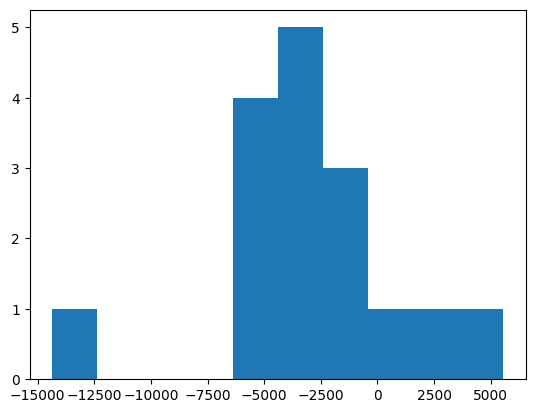

In [466]:
indices = mean_easter_sales["count"] == 6
plt.hist(mean_noneaster_sales.loc[indices] - mean_easter_sales.loc[indices, "mean"])

In [ ]:
(mean_easter_sales.loc[indices, "mean"] / mean_noneaster_sales.loc[indices]).mean()

np.float64(1.3557357825269003)

In [ ]:
indices = mean_easter_sales["count"] == 3
(mean_easter_sales.loc[indices, "mean"] / mean_noneaster_sales.loc[indices]).mean()

np.float64(0.4565018623702367)